## Skin Cancer Classification using HAM10000 Dataset

### Part 1 : Data pre-processing

### Dataset Description:

    1. The 6GB by volume dataset consists of images divided into two parts with 5001 and 5016 images in them respectively
    2. The metadata file contains the following details about the images:
        - lesion_id
        - image_id
        - dx 
        - dx_type
        - age 
        - sex
        - localisation
     dx -> indicates 
     dx_type -> indicates
     
     
### Data Exploration

Steps:

    1. Read meta data csv file into a pandas dataframe 
    
    2. Check for missing values
    
    3. Check the distribution of images across lesion types (dx)
    
    4. Visualise other elements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from glob import glob
import PIL
from PIL import Image
import shutil
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [2]:
meta_df = pd.read_csv('data/HAM10000_metadata.csv')

In [3]:
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
meta_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [5]:
print(meta_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [6]:
 #Extracting  label names to a list
label=meta_df['dx'].unique().tolist() 
print(label)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


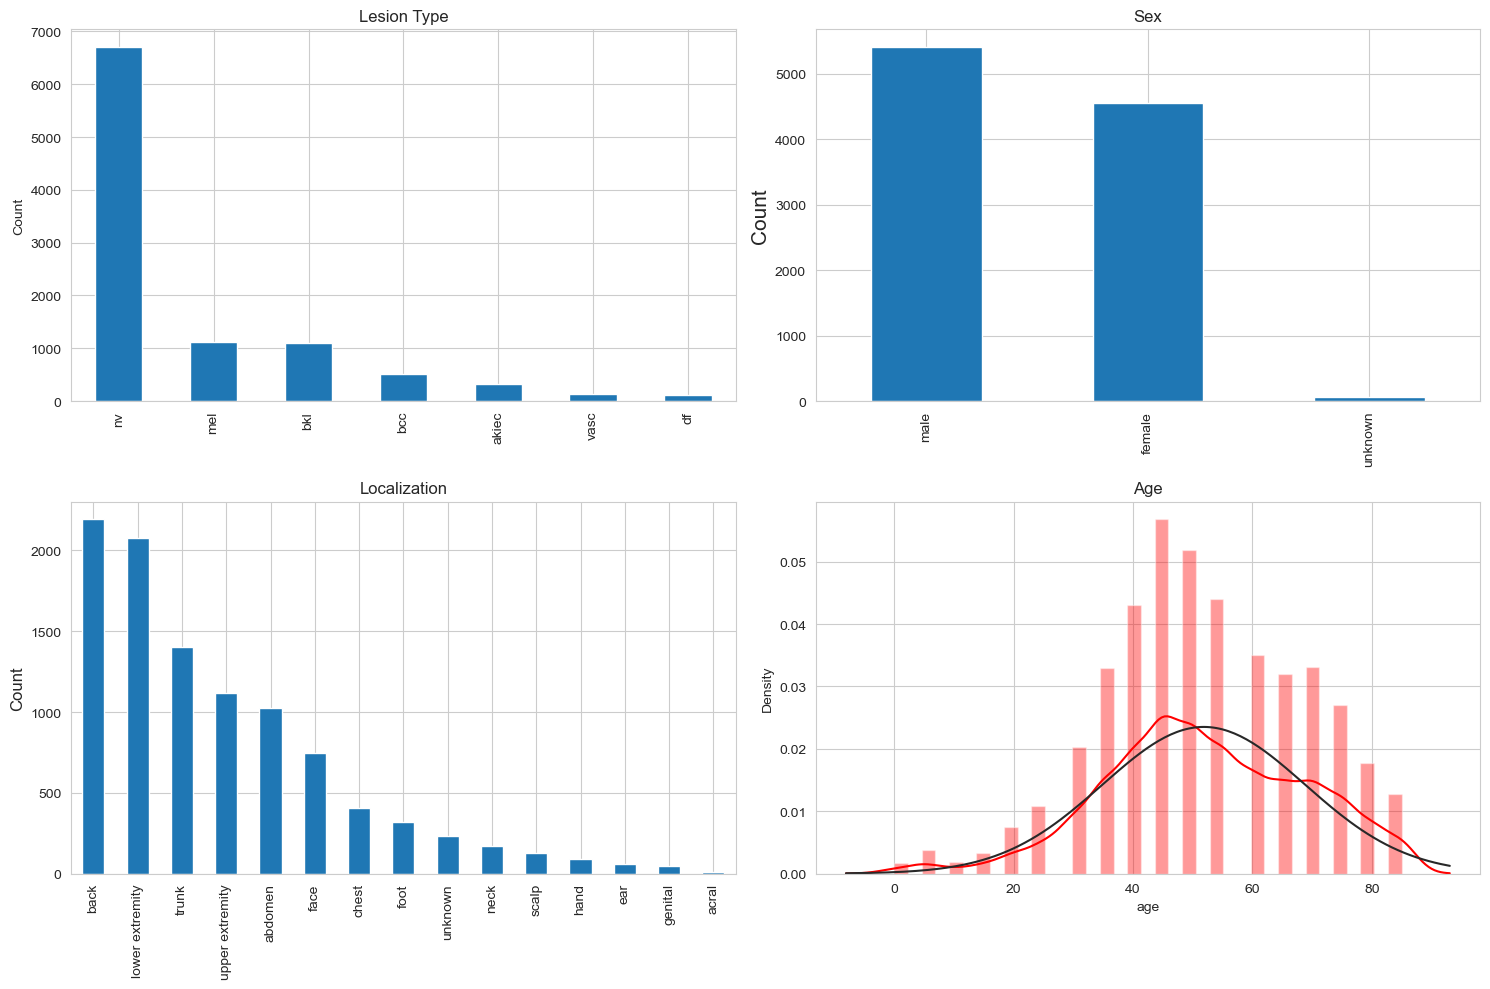

In [7]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
meta_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Lesion Type');

ax2 = fig.add_subplot(222)
meta_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
meta_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = meta_df[pd.notnull(meta_df['age'])]
sns.distplot(meta_df['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

### Observations:

    1. Dataset is highly imbalanced on type of lesion
    
    2. Distribution by gender is balanced 
    
    3. Localisation - 
    
### Data Balancing techniques 

There are a many ways to balance an imbalanced dataset, a few ways are taken into consideration for this project.

**Method 1:**

Over sampling minority class and Under sampling majority class 

Experiment with sample sizes:

    1. 250 samples each
    2. 500 samples each

**Method 2 :**

Over sampling with Data Augmentation and Under sampling

Experiment with sample sizes:

    1. 250 samples each
    
    2. 500 samples each

**Method 3:**

Class weights 

### Data processing 

**In Memory**

**In Batches using tensorflow Image Data Generator**

### Examining  Images 

**Note:** As it is not convenient to traverse through two folders for gathering images, I have combined them into one single folder named "all_images" which now consists of 10016 images in total.

We load single image using the PIL library to examine its properties

In [8]:
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.2.0


In [9]:
image = Image.open('data/all_images/ISIC_0024306.jpg')
# summarizing some details about the image
print(image.format)
print(image.mode)
print(image.size)

JPEG
RGB
(600, 450)


uint8
(450, 600, 3)


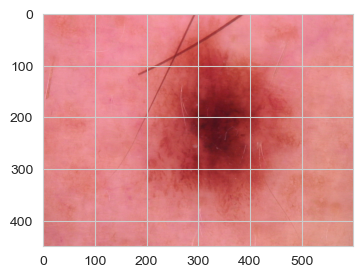

In [10]:
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
im_data = image.imread('data/all_images/ISIC_0024306.jpg')
# summarize shape of the pixel array
print(im_data.dtype)
print(im_data.shape)
# display the array of pixels as an image
plt.figure(figsize=(4,4))
pyplot.imshow(im_data)
pyplot.show()

### Creating Balanced Datasets

    1. With 250 images for each class. Name : skinlesion_250

    2. With 500 images for each class. Name : skinlesion_500
    
#### Method:

**Steps:**

    1. Use the meta data dataframe to filter out and resample images based on their labels into seperate dataframes. Used label encoding on 'dx' label feature.
    
    2. Combine the dataframes to create a new dataframe with balanced image labels 
    
    3. Use 'image_id' from the meta data to copy images from origin directory into their respective label in the destination directory. Resizing images to 256*256*3 - keeping a larger image size in order to not loose too much information. Can also experiment with different image sizes and see how it affects accuracy. 
    
    4. Split the destination directory into train,test and validation sets 



In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [12]:
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


#### step 1

In [16]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(meta_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [17]:
meta_df['label'] = le.transform(meta_df["dx"]) 
meta_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9479,HAM_0004392,ISIC_0033355,nv,consensus,20.0,female,lower extremity,5
215,HAM_0002894,ISIC_0033056,bkl,histo,40.0,female,abdomen,2
1971,HAM_0000201,ISIC_0031408,mel,histo,65.0,male,trunk,4
8254,HAM_0000342,ISIC_0027902,nv,histo,75.0,female,lower extremity,5
4832,HAM_0007055,ISIC_0031235,nv,follow_up,55.0,female,upper extremity,5


In [50]:
df_0 = meta_df[meta_df['label'] == 0]
df_1 = meta_df[meta_df['label'] == 1]
df_2 = meta_df[meta_df['label'] == 2]
df_3 = meta_df[meta_df['label'] == 3]
df_4 = meta_df[meta_df['label'] == 4]
df_5 = meta_df[meta_df['label'] == 5]
df_6 = meta_df[meta_df['label'] == 6]

In [60]:
meta_df['label'].value_counts().sort_index() 

0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
Name: label, dtype: int64

In [139]:
n_samples=250
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=41) #over sampling
df_1_balanced = resample(df_1, replace=False, n_samples=n_samples, random_state=41) # under sampling
df_2_balanced = resample(df_2, replace=False, n_samples=n_samples, random_state=41)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=41)
df_4_balanced = resample(df_4, replace=False, n_samples=n_samples, random_state=41)
df_5_balanced = resample(df_5, replace=False, n_samples=n_samples, random_state=41)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=41)

#### step 2

In [141]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [143]:
skin_df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 9767 to 2395
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     1750 non-null   object 
 1   image_id      1750 non-null   object 
 2   dx            1750 non-null   object 
 3   dx_type       1750 non-null   object 
 4   age           1748 non-null   float64
 5   sex           1750 non-null   object 
 6   localization  1750 non-null   object 
 7   label         1750 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 123.0+ KB


In [144]:
print(skin_df_balanced['dx'].value_counts())

akiec    250
bcc      250
bkl      250
df       250
mel      250
nv       250
vasc     250
Name: dx, dtype: int64


In [151]:
skin_df_balanced.reset_index(inplace=True,drop=True)
skin_df_balanced.head(2)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0006135,ISIC_0031044,akiec,histo,60.0,male,face,0
1,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,0


In [101]:
#origin directory
origin_dir = os.getcwd()+"/data/all_images/"
# Path to destination directory where we want subfolders
dest_dir = os.getcwd() + "/data/skinlesion_250/"

In [70]:
labels = list(le.classes_)
labels

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [147]:
# making sub directories for each label in the destination directory
for i in labels:
    os.mkdir(dest_dir + str(i) + "/")

#### step 3

In [148]:
# Copy images to new folders
# if image already exists - modify name and keep the copy to maintain balance 
label_images = []

for i in labels:
    sample = skin_df_balanced[skin_df_balanced['dx'] == i]['image_id']
    label_images.extend(sample)
    
    for id in label_images:
        if not os.path.exists(os.path.join(dest_dir+i+"/",id +".jpg")):
            shutil.copyfile((origin_dir + id +".jpg"), (dest_dir + i + "/" + id +".jpg"))
        else:
            j=1
            while os.path.exists(os.path.join(dest_dir+i+"/", '{}_{}{}'.format(id, j, ".jpg"))):
                j += 1
            shutil.copyfile((origin_dir + id +".jpg"), (dest_dir + i +"/"+'{}_{}{}'.format(id, j, ".jpg")))
    
    label_images=[] 

In [149]:
print("count nv:",len(os.listdir('data/skinlesion_250/nv'))) #checking number of items 

count nv: 250


In [22]:
def copy_w_duplicates(skin_df_balanced,origin_dir,dest_dir):
    label_images = []

    for i in labels:
        sample = skin_df_balanced[skin_df_balanced['dx'] == i]['image_id']
        label_images.extend(sample)

        for id in label_images:
            if not os.path.exists(os.path.join(dest_dir+i+"/",id +".jpg")):
                shutil.copyfile((origin_dir + id +".jpg"), (dest_dir + i + "/" + id +".jpg"))
            else:
                j=1
                while os.path.exists(os.path.join(dest_dir+i+"/", '{}_{}{}'.format(id, j, ".jpg"))):
                    j += 1
                shutil.copyfile((origin_dir + id +".jpg"), (dest_dir + i +"/"+'{}_{}{}'.format(id, j, ".jpg")))

        label_images=[] 

#### step 4

In [31]:
# !pip install split-folders
import splitfolders

In [29]:
# split data into train test and validation
def split_folders(input_folder,output_folder,ratio=(0.7,0.2,0.1)):   
    splitfolders.ratio(input_folder,output=output_folder,
                  seed =41, ratio=ratio,group_prefix=None)

In [165]:
# os.makedirs("data/skinlesion_250_split")

In [164]:
input_folder = "data/skinlesion_250"
output_folder = "data/skinlesion_250_split"
split_folders(input_folder,output_folder)

In [166]:
# checking count of train images in each sub-folder

print("count nv:",len(os.listdir('data/skinlesion_250_split/train/nv')))
print("count mel:",len(os.listdir('data/skinlesion_250_split/train/mel')))
print("count bkl:",len(os.listdir('data/skinlesion_250_split/train/bkl')))
print("count bcc:",len(os.listdir('data/skinlesion_250_split/train/bcc')))
print("count akiec:",len(os.listdir('data/skinlesion_250_split/train/akiec')))
print("count vasc:",len(os.listdir('data/skinlesion_250_split/train/vasc')))
print("count df:",len(os.listdir('data/skinlesion_250_split/train/df')))

count nv: 175
count mel: 175
count bkl: 175
count bcc: 175
count akiec: 175
count vasc: 175
count df: 175


In [167]:
# checking count of test images in each sub-folder

print("count nv:",len(os.listdir('data/skinlesion_250_split/test/nv')))
print("count mel:",len(os.listdir('data/skinlesion_250_split/test/mel')))
print("count bkl:",len(os.listdir('data/skinlesion_250_split/test/bkl')))
print("count bcc:",len(os.listdir('data/skinlesion_250_split/test/bcc')))
print("count akiec:",len(os.listdir('data/skinlesion_250_split/test/akiec')))
print("count vasc:",len(os.listdir('data/skinlesion_250_split/test/vasc')))
print("count df:",len(os.listdir('data/skinlesion_250_split/test/df')))

count nv: 25
count mel: 25
count bkl: 25
count bcc: 25
count akiec: 25
count vasc: 25
count df: 25


In [168]:
# checking count of validation images in each sub-folder

print("count nv:",len(os.listdir('data/skinlesion_250_split/val/nv')))
print("count mel:",len(os.listdir('data/skinlesion_250_split/val/mel')))
print("count bkl:",len(os.listdir('data/skinlesion_250_split/val/bkl')))
print("count bcc:",len(os.listdir('data/skinlesion_250_split/val/bcc')))
print("count akiec:",len(os.listdir('data/skinlesion_250_split/val/akiec')))
print("count vasc:",len(os.listdir('data/skinlesion_250_split/val/vasc')))
print("count df:",len(os.listdir('data/skinlesion_250_split/val/df')))

count nv: 50
count mel: 50
count bkl: 50
count bcc: 50
count akiec: 50
count vasc: 50
count df: 50


In [169]:
## deleting folder as it is no longer required
shutil.rmtree('data/skinlesion_250', ignore_errors=True)

### Automating creation of balanced dataset with a function

To create a balanced dataset "skinlesion_500" with 500 images of each label.
Prerequisites:

    1. pass in a dataframe that has lable encoded column called "label"
    
    2. Make destination directory named "skinlesion_500"
    
    3. pass in n_samples = 500

In [20]:
def create_balanced_dataset(df,n_samples,labels,origin_dir,des_dir):
    
    df_0 = df[df['label'] == 0]
    df_1 = df[df['label'] == 1]
    df_2 = df[df['label'] == 2]
    df_3 = df[df['label'] == 3]
    df_4 = df[df['label'] == 4]
    df_5 = df[df['label'] == 5]
    df_6 = df[df['label'] == 6]
    
    df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) #over sampling
    df_1_balanced = resample(df_1, replace=False, n_samples=n_samples, random_state=42) # under sampling
    df_2_balanced = resample(df_2, replace=False, n_samples=n_samples, random_state=42)
    df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
    df_4_balanced = resample(df_4, replace=False, n_samples=n_samples, random_state=42)
    df_5_balanced = resample(df_5, replace=False, n_samples=n_samples, random_state=42)
    df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)
    
    skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])
    skin_df_balanced.reset_index(inplace=True,drop=True)
     
    # making sub directories for each label in the destination directory
    for i in labels:
        os.mkdir(dest_dir + str(i) + "/")
    
    copy_w_duplicates(skin_df_balanced,origin_dir,dest_dir)
        
    '''This function returns a folder that is not split into train test val'''

In [14]:
#origin directory
origin_dir = os.getcwd()+"/data/all_images/"
# Path to destination directory where we want subfolders
dest_dir = os.getcwd() + "/data/skinlesion_500/"

labels = list(le.classes_)
labels

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [24]:
os.mkdir("data/skinlesion_500")

In [18]:
meta_df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2


In [25]:
create_balanced_dataset(meta_df,500,labels,origin_dir,dest_dir)

In [26]:
os.mkdir("data/skinlesion_500_split_8020")

In [32]:
input_folder = "data/skinlesion_500"
output_folder = "data/skinlesion_500_split_8020"
split_folders(input_folder,output_folder,ratio=(0.8,0.2))

In [182]:
## deleting folder as it is no longer required
shutil.rmtree('data/skinlesion_500', ignore_errors=True)

### Conclusion & Next steps:

This ends the priliminary pre processing of data into balanced datasets for further experimentation.

In the next section, I will be conducting the following experiments:

    1. Training & testing a simple CNN model with balanced data set of 250 samples each with an input size 256*256*3

    2. Training & testing a simple CNN model with balanced data set of 250 samples each with an input size 128*128*3

    3. Training & testing a simple CNN model with balanced data set of 250 samples each with an input size 32*32*3

**Objective:** To see if changing input image size changes model performance

    4. Training & testing simple CNN model with balanced data set of 500 samples each with an input size 256*256*3

    5. Training & testing a medium complex CNN model 

    6. Training & testing a complex CNN model 

**Objective:** To see how complexity of the network affects performance 

    7. Train and test with transfer learning with state of the art models like Mobilenet,Inceptionnet, Resnet etc